In [11]:
from itertools import product
from math import sqrt

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Aufgabe 1: Homogene Koordinaten

In [12]:
class Point:
    def __init__(self, x, y, z):
        self.p = np.array([x, y, z, 1])

    def translate(self, tx, ty, tz):
        translation_matrix = np.array([
            [1, 0, 0, tx],
            [0, 1, 0, ty],
            [0, 0, 1, tz],
            [0, 0, 0, 1]
        ])
        self.p = np.matmul(translation_matrix, self.p)

    def rotate_x(self, theta):
        translation_matrix = np.array([
            [1, 0, 0, 0],
            [0, np.cos(theta), np.sin(theta), 0],
            [0, -np.sin(theta), np.cos(theta), 0],
            [0, 0, 0, 1]
        ])
        self.p = np.matmul(translation_matrix, self.p)

    def rotate_y(self, theta):
        translation_matrix = np.array([
            [np.cos(theta), 0, -np.sin(theta), 0],
            [0, 1, 0, 0],
            [np.sin(theta), 0, np.cos(theta), 0],
            [0, 0, 0, 1]
        ])
        self.p = np.matmul(translation_matrix, self.p)

    def rotate_z(self, theta):
        translation_matrix = np.array([
            [np.cos(theta), -np.sin(theta), 0, 0],
            [np.sin(theta), np.cos(theta), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        self.p = np.matmul(translation_matrix, self.p)

    def scale(self, s):
        translation_matrix = np.array([
            [s, 0, 0, 0],
            [0, s, 0, 0],
            [0, 0, s, 0],
            [0, 0, 0, 1]
        ])
        self.p = np.matmul(translation_matrix, self.p)

In [26]:
p = Point(3, 7, 2)
p.p[:-1]

array([3, 7, 2])

In [27]:
p.translate(5, 2, 2)
p.p[:-1]

array([8, 9, 4])

In [28]:
p.rotate_y(np.pi / 2)
p.p[:-1]

array([-4.,  9.,  8.])

In [29]:
p.scale(3)
p.p[:-1]

array([-12.,  27.,  24.])

# Aufgabe 2: SIFT

In [30]:
from SIFT_KeyPoint import SIFT_KeyPoint
from SIFT_Params import SIFT_Params
from SIFT_Visualization import visualize_scale_space, visualize_keypoints

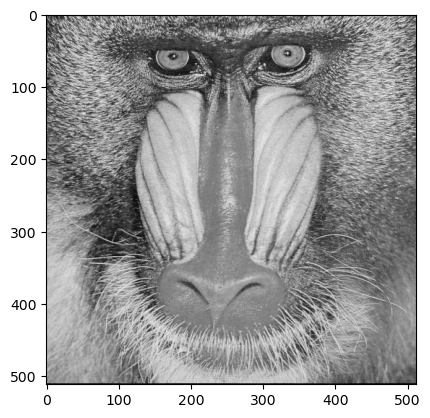

In [31]:
image = cv2.imread('../images/Mandrill.jpg', 0)
image = image / 255
plt.imshow(image, cmap=plt.get_cmap("gray"))

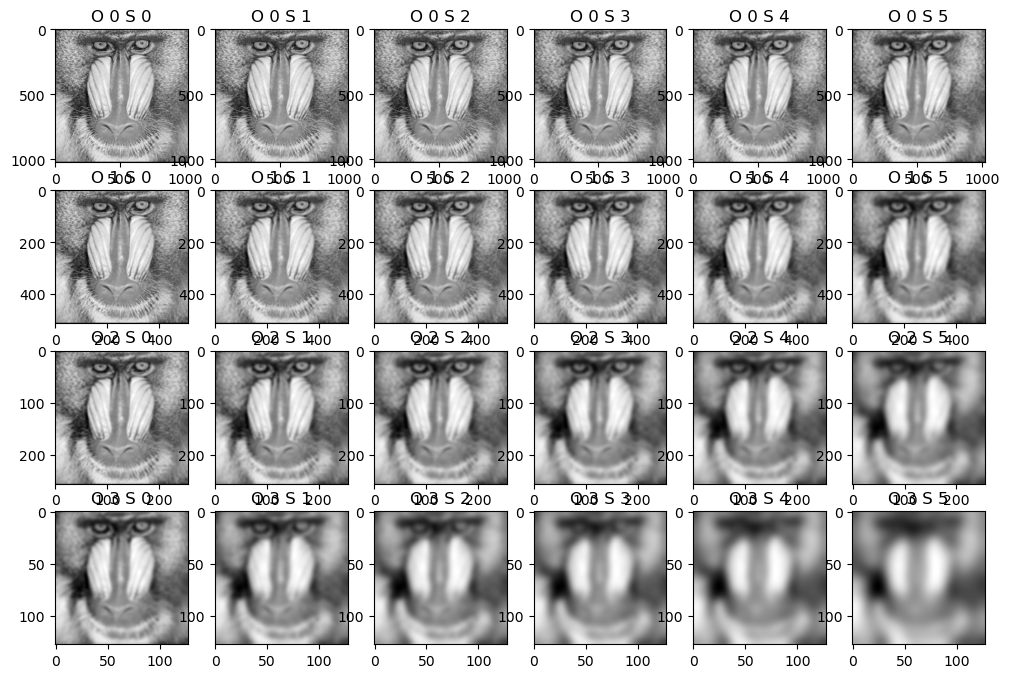

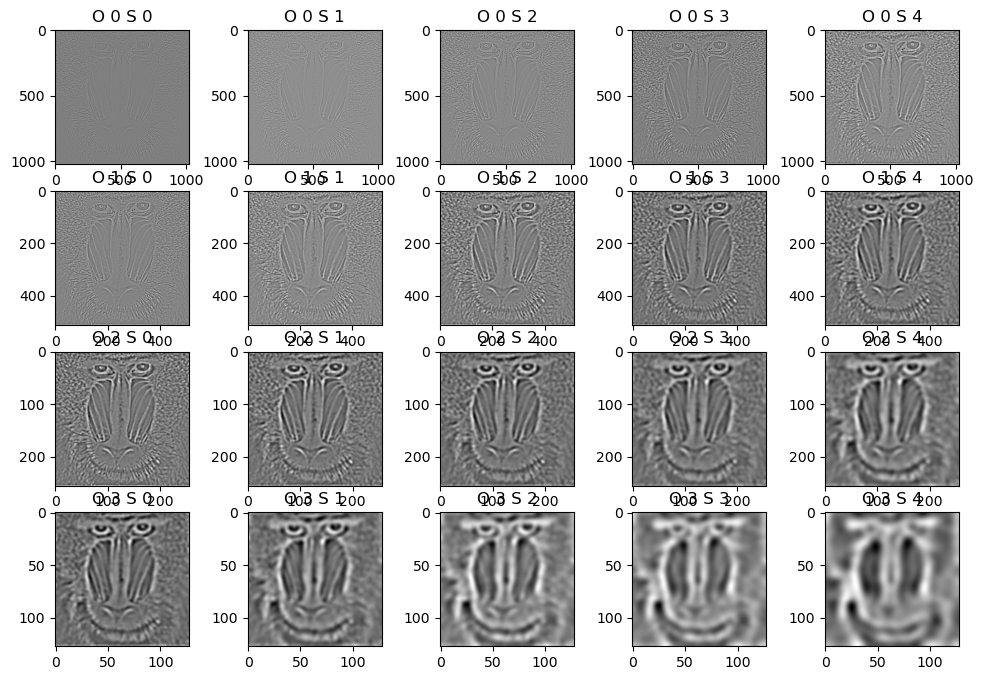

Extrema Calculation: Octave 0
Extrema Calculation: Octave 1
Extrema Calculation: Octave 2
Extrema Calculation: Octave 3


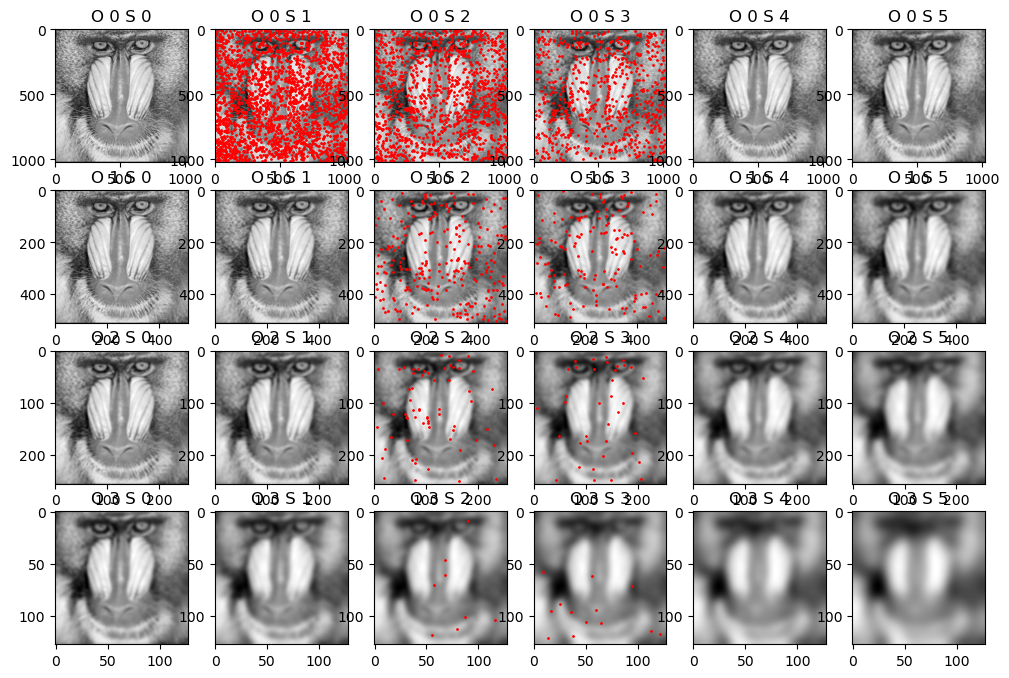

In [32]:
from SIFT_algo import SIFT_Algorithm
scale_space, deltas, sigmas = SIFT_Algorithm.create_scale_space(image, SIFT_Params())
visualize_scale_space(scale_space, "Gaussians")
dogs = SIFT_Algorithm.create_dogs(scale_space, SIFT_Params())
visualize_scale_space(dogs, "DoGs")
keypoints = SIFT_Algorithm.find_discrete_extremas(dogs, SIFT_Params(), sigmas, deltas)
visualize_keypoints(scale_space, keypoints, deltas, "Keypoints")

In [20]:
def getSigmas(sigma: float, params: SIFT_Params, mult=1):
    image_count = params.n_spo + 3  # +3 to have enough image for DoG later on

    sigmas = [sigma]
    for image_index in range(1, image_count):
        c_sigma = mult * params.sigma_min * (2 ** (image_index / params.n_spo))
        sigmas.append(c_sigma)
    return sigmas


def create_scale_space(image, params):
    # generate base image (scale up by factor 2 and apply blur)
    image = cv2.resize(
        image,
        (0, 0),
        fx=1 / params.delta_min,
        fy=1 / params.delta_min
    )

    sigma = params.sigma_min
    assumed_blur = params.sigma_in
    sigma_diff = sqrt(sigma ** 2 - assumed_blur ** 2) / params.delta_min
    image = cv2.GaussianBlur(image, (0, 0), sigma_diff)

    # compute images, sigma and delta for each octave
    scale_space = []
    sigmas = []
    deltas = [params.delta_min]
    for i in range(params.n_oct):
        if i != 0:
            deltas.append(deltas[-1] * 2)
            sigma = sigmas[i - 1][params.n_spo - 1]  # last valid sigma

        sigmas.append(getSigmas(sigma, params, (deltas[-1]) / params.delta_min))

        gaussian_images_in_octave = [image]
        for s_prev, s_cur in zip(sigmas[i][:-1], sigmas[i][1:]):
            new_sigma = sqrt(s_cur ** 2 - s_prev ** 2) / deltas[-1]
            image = cv2.GaussianBlur(image, (0, 0), new_sigma)
            gaussian_images_in_octave.append(image)

        scale_space.append(gaussian_images_in_octave)
        o_base_image = gaussian_images_in_octave[params.n_spo - 1]  # image with correct blur
        image = cv2.resize(o_base_image, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)

    return scale_space, deltas, sigmas


def create_dogs(scale_space):
    return [[cv2.subtract(cur, prev) for prev, cur in zip(scale, scale[1:])] for scale in scale_space]


def find_discrete_extremas(dogs, border=1):
    keypoints = []
    for octave, o_images in enumerate(dogs):
        for scale, s_images in enumerate(zip(o_images, o_images[1:], o_images[2:])):
            space = np.array(s_images)
            x_axis = range(border, space.shape[1] - border)
            y_axis = range(border, space.shape[2] - border)
            for x, y in product(x_axis, y_axis):
                cube = space[:,x - 1: x + 2, y - 1: y + 2]
                center = cube[1,1,1]
                cube[1,1,1] = 0  #  TODO this should be np.delete instead
                if np.max(cube) < center or np.min(cube) > center:
                    keypoints.append(SIFT_KeyPoint(octave, scale+1, y, x))
    return keypoints

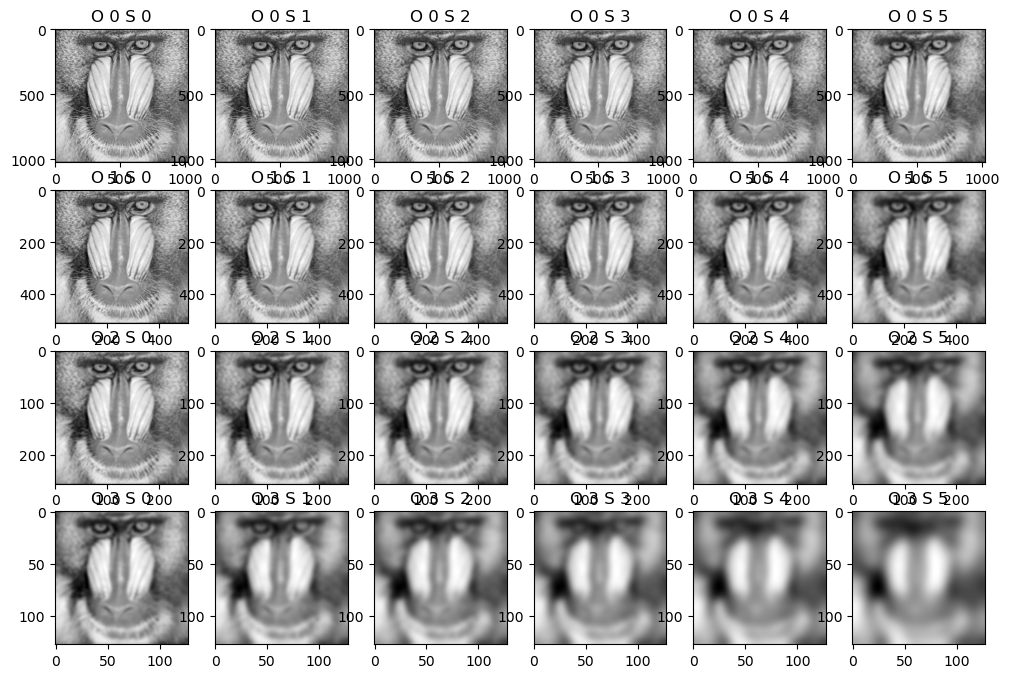

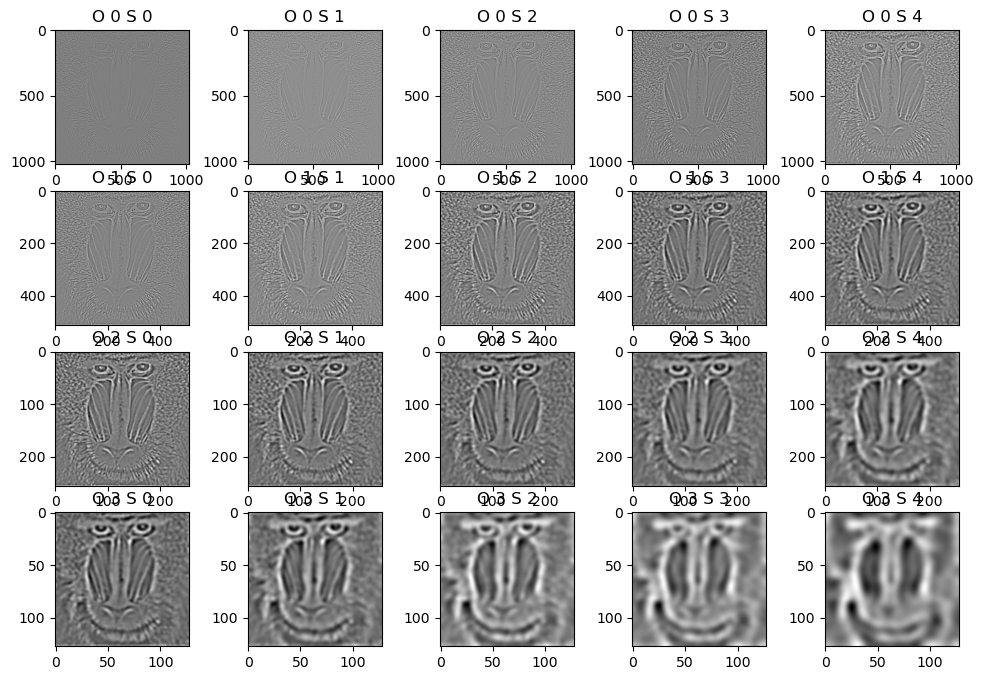

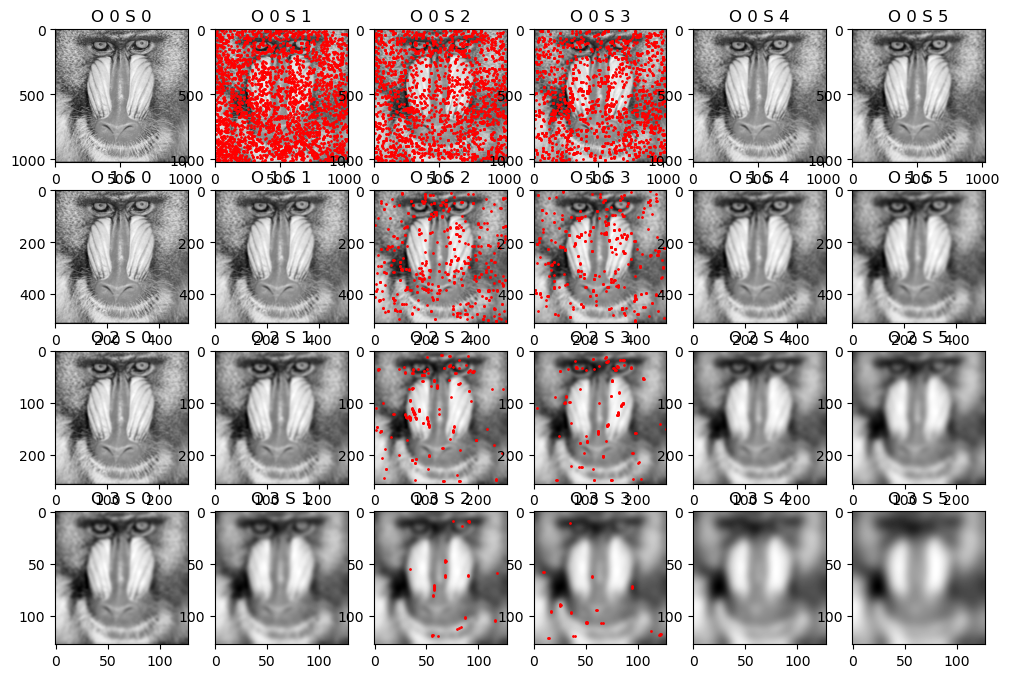

In [33]:
scale_space, deltas, sigmas = create_scale_space(image, SIFT_Params())
visualize_scale_space(scale_space, "Gaussians")
dogs = create_dogs(scale_space)
visualize_scale_space(dogs, "DoGs")
keypoints = find_discrete_extremas(dogs)
visualize_keypoints(scale_space, keypoints, deltas, "Keypoints")